## Image Colorization Network
I employ U-Net architecture described by [Ronneberger et. Al (2015)](https://arxiv.org/pdf/1505.04597.pdf) to predict how to colorize a grayscale image

Images can be represented in two ways: the *RGB* space and the *Lab* space. In the latter, *L* denotes lightness, *a* denotes the green-red spectrum, and *b* denotes the blue-yellow spectrum. Thus, an image whose *a* and *b* values are stripped (i.e. set to 0) is a grayscale image.

Thus, the grayscale image can be represented as a matrix $X   \epsilon   \mathbb{R}^{l*w}$, where *l* and *w* are the dimensions of the image. The goal of the neural network is to take this as an input and output $ \hat{Y}   \epsilon   \mathbb{R}^{l*w*2}$, the matrix that represents the predicted *a* and *b* values for each pixel in the image.

In [18]:
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras import losses
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
from IPython.display import Image

First, we take the requested image and transform it into a vector. Then, we convert from the standard *RGB* format into the *Lab* format so we can acquire the *L* values for each pixel. We then standardize these values by dividing them by 255, so that each value now rests between 0 and 1. Finally, we reshape our vector into the dimensions of the original image

In [19]:
def convert_image(file, size):
    image = img_to_array(load_img(file))
    image = np.array(image, dtype=float)
    # Import map images into the lab colorspace
    X = rgb2lab(1.0/255*image)[:,:,0]
    Y = rgb2lab(1.0/255*image)[:,:,1:]
    Y = Y / 128
    X = X.reshape(1, size, size, 1)
    Y = Y.reshape(1, size, size, 2)
    return X,Y

Next, we train the algorithm to color the image by passing it through our convolutional neural network. This CNN progressively downsamples the image by reducing the height and width of the image by a factor of two while doubling the number of channels after each convolution. The network maintains a continuous kernel size of $3x3$, and employs the *ReLU* activation function after each convolution to standardize the output space. Finally, we upsample the image and half the number of channels before producing our final result.

Note that the network does not employ any *pooling*, as this would distort the image, which we cannot allow as the relative locations of pixels across the image is necessary information for the network.

In [20]:
def train_model(file,epochs, size):
    X,Y = convert_image(file, size)
    
    model = Sequential()
    model.add(InputLayer(input_shape=(None, None, 1)))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
    
    model.compile(optimizer='rmsprop',loss='mse')
    model.fit(x=X, y=Y, batch_size=1, epochs=epochs)
    
    return model

Finally, after our model has successfully completed its training, we can colorize the grayscale image using the weights from our model. We simply pass the input matrix $X$ to the model, and it returns the matrix corresponding to the *a* and *b* values for each pixel. We pair these two matrices together to obtain our final colorized image.

In [26]:
def colorize_image(file, model, size):
    X,_ = convert_image(file,size)
    # Output colorizations
    output = model.predict(X)
    output = output * 128
    canvas = np.zeros((size, size, 3))
    canvas[:,:,0] = X[0][:,:,0]
    canvas[:,:,1:] = output[0]
    imsave(file[5:6] + "_result.png", lab2rgb(canvas))

Let's test our algorithm on this image of these trees:

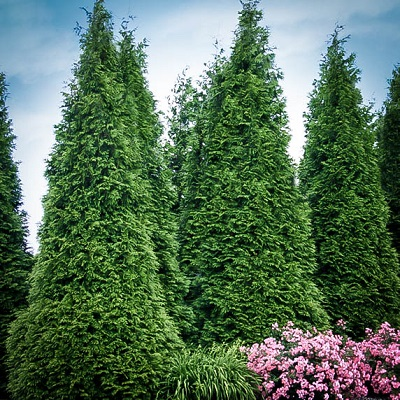

In [22]:
Image("img\trees1.jpg")

Here is the grayscale image we will be coloring:

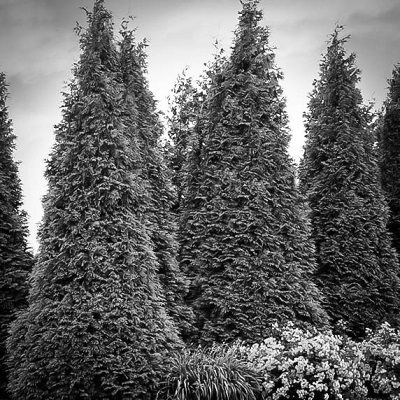

In [33]:
Image("img\trees1_g.jpg")

First we train the model on the colored image...

In [ ]:
model = train_model('img\trees1.jpg',600, 400)

...then we see how it attempts to color the grayscale attempt of the same image.

In [ ]:
colorize_image('img\trees1_g.jpg',model, 400)

And here is our colorized image! Pretty much identical to the original!

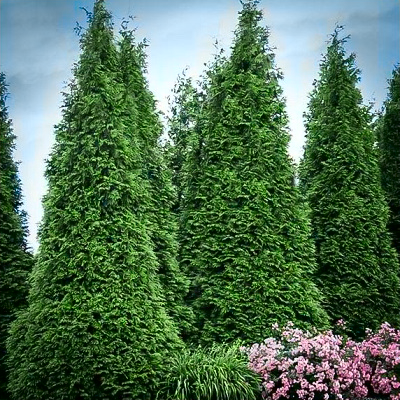

In [28]:
Image("img\1_result.png")

This is not surprising considering we trained the algorithm *using* this image. But how will it color an image it has never seen before? Let's test that using this other image of trees:

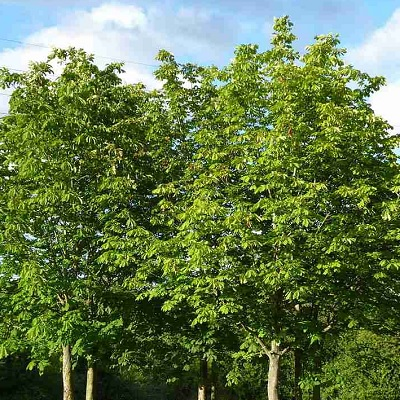

In [34]:
Image("img\trees2.jpg")

Remember, we won't show the algorithm this image. All we provide it is this grayscale copy of the image:

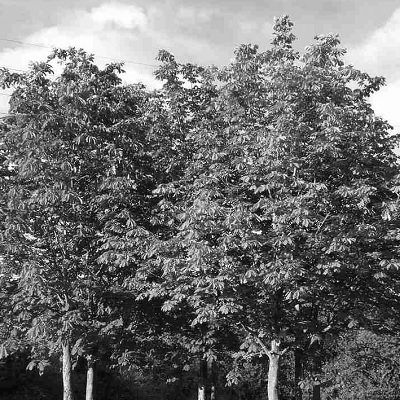

In [35]:
Image("img\trees2_g.jpg")

Let's see how the CNN colors this image!

In [ ]:
colorize_image('img\trees2.jpg',model, 400)

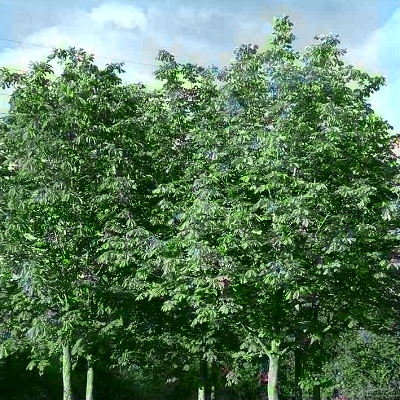

In [32]:
Image("img\2_result.png")

Not bad! You can see a slight tint of blue on the trees as the algorithm struggles to color between the leaves, but overall the coloring is fairly decent!